# Exploratory Data Analysis of Assuta Ramat HaHayal 2024 Surgical and Bed Occupancy Data

In this notebook, we conduct a detailed Exploratory Data Analysis (EDA) on the 2024 operating room dataset provided by Assuta Ramat HaHayal. Our objectives are to verify data integrity, resolve any chronological inconsistencies, engineer key features, and prepare the data for downstream statistical analysis and predictive modeling.

**1. Data Loading and Inspection**  
- We import essential libraries (`pandas`, `numpy`, `matplotlib.pyplot`, `scipy.stats`, `ydata_profiling`, etc.).  
- We load the primary 2024 Excel file (e.g. `Assuta RH 2024.xlsx`) and any supplementary tables containing patient metadata or pre-cleaned conflict outputs.  
- We inspect the first records, column names, data types, and basic summaries to confirm that dates, times, and categorical fields have been parsed correctly.

**2. Initial Cleaning and Copying**  
- We create a working copy of the raw DataFrame to preserve original data.  
- We remove duplicate rows and filter out “No Show” entries that should not contribute to analyses.  
- We handle missing values by dropping or imputing based on contextual requirements.

**3. Date & Time Parsing and Timestamp Construction**  
- We convert all relevant date columns (planned surgery dates, actual OR entry and exit, recovery, discharge) into `datetime` objects.  
- We parse time-only fields (planned block start/end times, incision, closure, actual entry/exit times) into `timedelta` or `datetime.time`.  
- We merge dates with their corresponding times to build unified timestamp columns (`Planned Start DateTime`, `Planned End DateTime`, `Entry DateTime`, `Incision DateTime`, `Closure DateTime`, `Exit DateTime`).

**4. Feature Engineering**  
- We calculate key time-based metrics:  
  - **Surgery Duration** (difference between exit and entry, in minutes)  
  - **Room Turnover Time** (difference between closure and previous surgery exit)  
  - **Start Delay** (difference between actual entry and planned start)  
- We implement custom functions to compute plan-vs-actual schedule success rates, quantifying adherence to planned times.

**5. Chronological Conflict Detection**  
- We identify internal inconsistencies (e.g., exit before entry) and correct or flag those records.  
- We review inter-case chronological overlaps or gaps, logging the number of corrections applied.

**6. Statistical Exploration and Visualization**  
- We generate descriptive statistics (mean, median, standard deviation) for all numeric features.  
- We visualize distributions and detect outliers using histograms, boxplots, and correlation heatmaps.  
- We perform normality tests (Shapiro–Wilk) and comparative analyses (t-tests, ANOVA) to examine differences across surgical categories.

**7. Automated Data Profiling**  
- We run the `ydata_profiling` toolkit to produce an interactive HTML report that summarizes data completeness, distributions, and high-level correlations.

**8. Export of Cleaned & Enriched Dataset**  
- We save the final cleaned and feature-enriched DataFrame to `2024_data_Assuta_nomissings_for_stat_final.xlsx` for further modeling, dashboarding, and strategic decision-making.

By following these steps, we ensure that the 2024 surgical and bed–occupancy data are reliable, well-understood, and enriched—laying a solid foundation for robust predictive modeling and operational insights.  

In [ ]:
#Import of libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import itertools
from pandas.api.types import is_numeric_dtype
from scipy.stats import shapiro
from tqdm import tqdm

In [ ]:
file_path = r"/content/Assuta RH 2024.xlsx"
df = pd.read_excel(file_path)
print(df.head())

   Site Code  Main Surgeon Code  Activity Code  Activity Type Code  \
0         20                  0           49.4                  12   
1         20                  0           49.4                  12   
2         20                184           35.0                  14   
3         20                184           35.0                  14   
4         20                184           35.0                  14   

   Planned SU Time (Large/Medium/Small) Pre-Surgery Admission Date  Height  \
0                                  20.0                 2023-08-29    1.61   
1                                  20.0                 2023-08-29    1.61   
2                                   NaN                        NaT    1.60   
3                                   NaN                        NaT    1.60   
4                                   NaN                        NaT    1.60   

   Weight  Patient Age (on Surgery Day)  \
0    51.0                            32   
1    51.0               

In [ ]:
print(df.columns)

Index(['Site Code', 'Main Surgeon Code', 'Activity Code', 'Activity Type Code',
       'Planned SU Time (Large/Medium/Small)', 'Pre-Surgery Admission Date',
       'Height', 'Weight', 'Patient Age (on Surgery Day)',
       'Background Diseases/Diagnoses', 'Planned Surgery Date',
       'Planned Surgery Time', 'Surgery Admission Date',
       'Administrative Admission Time', 'אתר מתוכנן',
       'Planned Operating Room Number',
       'Pre-Surgery Hospitalization Admission Date',
       'Pre-Surgery Hospitalization Admission Time',
       'Pre-Surgical Admission Time Before Surgery', 'Surgical Team Codes',
       'Anesthesiologist Code', 'Anesthesia Code', 'Type of Anesthesia',
       'Cancellation Reason on Surgery Day', 'Actual Operating Room Number',
       'Actual Surgery Room Entry Date', 'Actual Surgery Room Entry Time',
       'Incision Time', 'Closure Time', 'End of Surgery Date (Exit from OR)',
       'End of Surgery Time (Exit from OR)', 'Planned Surgery Duration',
       'Rec

In [ ]:
print(df.dtypes)

Site Code                                              int64
Main Surgeon Code                                      int64
Activity Code                                        float64
Activity Type Code                                     int64
Planned SU Time (Large/Medium/Small)                 float64
Pre-Surgery Admission Date                    datetime64[ns]
Height                                               float64
Weight                                               float64
Patient Age (on Surgery Day)                           int64
Background Diseases/Diagnoses                         object
Planned Surgery Date                          datetime64[ns]
Planned Surgery Time                                  object
Surgery Admission Date                        datetime64[ns]
Administrative Admission Time                         object
אתר מתוכנן                                            object
Planned Operating Room Number                        float64
Pre-Surgery Hospitalizat

In [ ]:
df_copy=df.copy()

In [ ]:
print(df_copy.head(10))

   Site Code  Main Surgeon Code  Activity Code  Activity Type Code  \
0         20                  0           49.4                  12   
1         20                  0           49.4                  12   
2         20                184           35.0                  14   
3         20                184           35.0                  14   
4         20                184           35.0                  14   
5         20                184           35.0                  14   
6         20                184           35.0                  14   
7         20                184           35.0                  14   
8         20                184           35.0                  14   
9         20                  0           49.4                  12   

   Planned SU Time (Large/Medium/Small) Pre-Surgery Admission Date  Height  \
0                                  20.0                 2023-08-29    1.61   
1                                  20.0                 2023-08-29    1.6

In [ ]:
# Setting up date and time columns
date_cols = [
    'Planned Surgery Date',
    'Pre-Surgery Admission Date',
    'Pre-Surgery Hospitalization Admission Date',
    'Actual Surgery Room Entry Date',
    'End of Surgery Date (Exit from OR)',
    'Recovery Room Entry Date',
    'Recovery Room Exit Date',
    'Post-Surgery Discharge Date',
    'Surgery Admission Date',
    'Planned Start Date for Doctor Block',
    'Planned End Date for Doctor Block'
]

time_cols = [
    'Actual Surgery Room Entry Time',
    'End of Surgery Time (Exit from OR)',
    'Incision Time',
    'Closure Time',
    'Recovery Room Entry Time',
    'Recovery Room Exit Time',
    'Post-Surgery Discharge Time',
    'Administrative Admission Time'
]

#Convert to real dates (without converting to str)
for col in date_cols:
    if col in df_copy.columns:
        df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')

# Convert to time only (to save only time without date)
for col in time_cols:
    if col in df_copy.columns:
        df_copy[col] = pd.to_datetime(df_copy[col], format='%H:%M:%S', errors='coerce').dt.time


for col in time_cols:
    if col in df_copy.columns:
        df_copy[col] = pd.to_datetime(df_copy[col], format='%H:%M:%S', errors='coerce').dt.strftime('%H:%M:%S')

# Create a unique strong signature (each field is converted to pre-written text)
df_copy['strict_signature'] = (
    df_copy['Height'].astype(str) + "_" +
    df_copy['Weight'].astype(str) + "_" +
    df_copy['Patient Age (on Surgery Day)'].astype(str) + "_" +
    df_copy['Actual Operating Room Number'].astype(str) + "_" +
    df_copy['Actual Surgery Room Entry Date'].astype(str) + "_" +
    df_copy['Actual Surgery Room Entry Time'].astype(str) + "_" +
    df_copy['End of Surgery Time (Exit from OR)'].astype(str) + "_" +
    df_copy['Incision Time'].astype(str) + "_" +
    df_copy['Closure Time'].astype(str) + "_" +
    df_copy['Recovery Room Entry Time'].astype(str) + "_" +
    df_copy['Recovery Room Exit Time'].astype(str) + "_" +
    df_copy['Post-Surgery Discharge Date'].astype(str) + "_" +
    df_copy['Post-Surgery Discharge Time'].astype(str)
)

# Create a unique identifier for each signature (patient-operating room)
df_copy['patient_id'] = df_copy.groupby('strict_signature', sort=False).ngroup() + 1

# Sort by ID and percentage of deficiencies (so we can complete later by the complete row)
df_copy['null_count'] = df_copy.isnull().sum(axis=1)
df_copy = df_copy.sort_values(by=['patient_id', 'null_count'])
df_copy.drop(columns=['null_count'], inplace=True)

df_copy.to_excel("patients_with_ids_and_signatures2024.xlsx", index=False)

In [ ]:
df_copy['Pre-Surgery Admission Date'].dt.year.value_counts()

,count
Pre-Surgery Admission Date,
2023.0,184491
2024.0,22


Creating a column for a no-Show:

In [ ]:
file_path = r"/content/patients_with_ids_and_signatures2024.xlsx"
df_no_show = pd.read_excel(file_path)

# We will define the critical columns for carrying out the actual analysis
surgery_real_cols = [
    'Actual Surgery Room Entry Date',
    'Actual Surgery Room Entry Time',
    'Incision Time',
    'Closure Time',
    'End of Surgery Date (Exit from OR)',
    'End of Surgery Time (Exit from OR)'
]

# We will create a new column called 'No Show' – if all these fields are missing, we will mark True
df_no_show['No Show'] = df_no_show[surgery_real_cols].isnull().all(axis=1)

print(f"Number of patients marked as No Show: {df_no_show['No Show'].sum()} of {len(df_no_show)}")
df_no_show.to_excel("patients_with_id_NS2024.xlsx", index=False)

Number of patients marked as No Show: 101 of 290704


###  **Chronological Conflict Cleaner for Surgery Timelines**

This code performs automated cleaning of surgical scheduling data to ensure logical consistency between critical timestamps:

1. **Datetime Parsing**
   Converts the columns `Entry DateTime`, `Incision DateTime`, `Closure DateTime`, and `Exit DateTime` to proper datetime format.

2. **Internal Conflict Detection (within the same row)**
   Ensures that the sequence of timestamps within each surgery is chronologically correct:

   
   Entry < Incision < Closure < Exit
   

   If a conflict is found (e.g., Incision is earlier than Entry), the most suspicious timestamp is removed (`NaT`), based on its position and surrounding values.

3. **Forward Inter-row Conflict Detection (current Exit vs. next Entry)**
   Ensures that one patient does not leave the OR after the next patient has already entered. If such an overlap is found, the `Exit DateTime` of the current row is removed.

4. **Backward Inter-row Conflict Detection (previous Exit vs. current Entry)**
   Ensures that a patient does not enter the OR before the previous one has exited. If such an overlap is detected, the `Exit DateTime` of the **previous row** is removed.

5. **Logging and Reporting**
   All removed values are stored in a list called `deleted_cells`, and a summary is printed showing how many issues were fixed, with a preview of up to 5 removed values.

In [ ]:
import pandas as pd

file_path = r"/content/patients_with_id_NS2024.xlsx"
df_copy = pd.read_excel(file_path)

df_copy["Entry DateTime"] = df_copy["Actual Surgery Room Entry Date"] + pd.to_timedelta(df_copy["Actual Surgery Room Entry Time"].astype(str), errors='coerce')
df_copy["Incision DateTime"] = df_copy["Actual Surgery Room Entry Date"] + pd.to_timedelta(df_copy["Incision Time"].astype(str), errors='coerce')
df_copy["Closure DateTime"] = df_copy["End of Surgery Date (Exit from OR)"] + pd.to_timedelta(df_copy["Closure Time"].astype(str), errors='coerce')
df_copy["Exit DateTime"] = df_copy["End of Surgery Date (Exit from OR)"] + pd.to_timedelta(df_copy["End of Surgery Time (Exit from OR)"].astype(str), errors='coerce')

# List of datetime columns to be validated
time_cols = ["Entry DateTime", "Incision DateTime", "Closure DateTime", "Exit DateTime"]

# Ensure datetime columns are parsed correctly
for col in time_cols:
    df_copy[col] = pd.to_datetime(df_copy[col], errors='coerce')

# Counters and log of removed invalid cells
internal_corrections = 0
external_corrections = 0
deleted_cells = []

# Part A: Resolve internal chronological conflicts within a single row
def clean_internal_conflicts(row):
    global internal_corrections
    for i in range(len(time_cols) - 1):
        col1 = time_cols[i]
        col2 = time_cols[i + 1]
        t1 = row[col1]
        t2 = row[col2]

        if pd.notnull(t1) and pd.notnull(t2) and t1 > t2:
            prev_time = row[time_cols[i - 1]] if i > 0 else None
            next_time = row[time_cols[i + 2]] if i + 2 < len(time_cols) else None

            if prev_time is not None and pd.notnull(prev_time) and prev_time > t1:
                bad_col = col1
            elif next_time is not None and pd.notnull(next_time) and t2 > next_time:
                bad_col = col2
            else:
                bad_col = col1  # default choice if context is unclear

            deleted_cells.append((row.name, bad_col, row[bad_col]))
            row[bad_col] = pd.NaT
            internal_corrections += 1
    return row

df_copy = df_copy.apply(clean_internal_conflicts, axis=1)

# Part B: Resolve conflict where current row's Exit is after the next row's Entry
df_copy["next_Entry DateTime"] = df_copy["Entry DateTime"].shift(-1)

def fix_external_conflict(row):
    global external_corrections
    if pd.notnull(row["Exit DateTime"]) and pd.notnull(row["next_Entry DateTime"]):
        if row["Exit DateTime"] > row["next_Entry DateTime"]:
            deleted_cells.append((row.name, "Exit DateTime", row["Exit DateTime"]))
            row["Exit DateTime"] = pd.NaT
            external_corrections += 1
    return row

df_copy = df_copy.apply(fix_external_conflict, axis=1)
df_copy.drop(columns=["next_Entry DateTime"], inplace=True)

# Part C: Resolve conflict where Entry of current row is before Exit of previous row → always delete Exit of previous row
df_copy["prev_Exit DateTime"] = df_copy["Exit DateTime"].shift(1)

def fix_inter_row_conflict_strict(row):
    global external_corrections
    entry = row["Entry DateTime"]
    prev_exit = row["prev_Exit DateTime"]

    if pd.notnull(entry) and pd.notnull(prev_exit) and entry < prev_exit:
        idx_prev = row.name - 1
        deleted_cells.append((idx_prev, "Exit DateTime", df_copy.at[idx_prev, "Exit DateTime"]))
        df_copy.at[idx_prev, "Exit DateTime"] = pd.NaT
        external_corrections += 1

    return row

df_copy = df_copy.apply(fix_inter_row_conflict_strict, axis=1)
df_copy.drop(columns=["prev_Exit DateTime"], inplace=True)

# Summary printout
print(f" Cleaning completed:")
print(f" {internal_corrections} internal conflicts resolved within rows.")
print(f" {external_corrections} inter-row conflicts resolved.")

# Display sample of removed values
if deleted_cells:
    print("\n Sample of removed values (up to 5 shown):")
    for row_idx, col, val in deleted_cells[:5]:
        print(f" Row {row_idx}, Column '{col}', Removed Value: {val}")
else:
    print("No values were removed.")

df_copy.to_excel("Chronological_Conflict_Cleaner2024.xlsx", index=False)

 Cleaning completed:
 16658 internal conflicts resolved within rows.
 269007 inter-row conflicts resolved.

 Sample of removed values (up to 5 shown):
 Row 0, Column 'Closure DateTime', Removed Value: 2023-09-04 13:17:00
 Row 1, Column 'Closure DateTime', Removed Value: 2023-09-04 13:17:00
 Row 2, Column 'Closure DateTime', Removed Value: 2023-09-04 13:17:00
 Row 3, Column 'Closure DateTime', Removed Value: 2023-09-04 13:17:00
 Row 4, Column 'Closure DateTime', Removed Value: 2023-09-04 13:17:00


Step 1: Completing missing values ​​from other rows of the same patient
How to do it:
Group by patient_id.

For each column with missing values ​​(NaN):

Check if other rows of the same patient in the same column have a valid value.

If so → fill the missing row with that value.

If there is more than one different value → select the most common value (or identify an exception if necessary).

Texts (such as Background Diseases/Diagnoses):
Find the longest version (with the most words or characters).

If there are multiple different versions → combine them into a long sentence with a separator (e.g. ; or |).

A new colum of possible imputation was made for clarity.

If there are missing values ​​in the columns, and an identical value is found for the same patient and the same surgeon, we will use it to complete the missing values.

Look at neighbors (different ID) on the same day in the operating room - if it is possible to complete neighbors, for example completing a closing time when it is known that the next ID in line started surgery at a certain time. This also applies to the start time of surgery, etc.

In addition, if there is a date scheduled for surgery, I want to check what % of the times there were no emergency rooms and the surgery was actually performed. At most, it can be completed from there if it is a case where there is really no one to complete from the neighbors, let's say only 1 patient was in surgery that day in the same room...

In [ ]:
# Calculating success rates – analysis of what actually took place from what was planned
def calculate_surgery_plan_success_rate(df_copy,
                                        planned_date_col='Planned Surgery Date',
                                        actual_date_col='Actual Surgery Room Entry Date'):

    df_check = df_copy[[planned_date_col, actual_date_col]].dropna(subset=[planned_date_col])
    df_check['same_day'] = df_check[planned_date_col] == df_check[actual_date_col]

    total_with_planned = len(df_check)
    actually_done_same_day = df_check['same_day'].sum()

    success_rate = (actually_done_same_day / total_with_planned) * 100 if total_with_planned > 0 else 0

    print(f"Percentage of actual planned surgery date realization: {success_rate:.1f}% ({actually_done_same_day}/{total_with_planned})")

    return success_rate

In [ ]:
calculate_surgery_plan_success_rate(df_copy)

Percentage of actual planned surgery date realization: 96.9% (274368/283071)


np.float64(96.92550632173553)

In [ ]:
#To the end of a date! Calculating success rates – an analysis of what actually took place from what was planned
def calculate_surgery_plan_success_rate2(df_copy,
                                        planned_date_col='Planned End Date for Doctor Block',
                                        actual_date_col='End of Surgery Date (Exit from OR)'):

    df_check = df_copy[[planned_date_col, actual_date_col]].dropna(subset=[planned_date_col])
    df_check['same_day'] = df_check[planned_date_col] == df_check[actual_date_col]

    total_with_planned = len(df_check)
    actually_done_same_day = df_check['same_day'].sum()

    success_rate = (actually_done_same_day / total_with_planned) * 100 if total_with_planned > 0 else 0

    print(f"Percentage of actual planned surgery date realization: {success_rate:.1f}% ({actually_done_same_day}/{total_with_planned})")

    return success_rate

In [ ]:
calculate_surgery_plan_success_rate2(df_copy)

Percentage of actual planned surgery date realization: 96.7% (273913/283225)


np.float64(96.71215464736517)

In [ ]:
file_path = r"/content/Chronological_Conflict_Cleaner2024.xlsx"
df_input = pd.read_excel(file_path)

def fill_actual_dates_from_block(df,
                                 start_actual_col='Actual Surgery Room Entry Date',
                                 start_planned_col='Planned Start Date for Doctor Block',
                                 end_actual_col='End of Surgery Date (Exit from OR)',
                                 end_planned_col='Planned End Date for Doctor Block',
                                 no_show_col='No Show'):
    df_filled = df.copy()

# Completion of start date – only for those who are No Show
    start_mask = (
        df_filled[start_actual_col].isnull() &
        df_filled[start_planned_col].notnull() &
        (~df_filled[no_show_col])  # Only if it's not a No Show
    )
    df_filled.loc[start_mask, start_actual_col] = df_filled.loc[start_mask, start_planned_col]
    print(f"Completed {start_mask.sum()} Start dates from Planned Start Date for Doctor Block.")

    # Completion of end date – only for those who are not No Show
    end_mask = (
        df_filled[end_actual_col].isnull() &
        df_filled[end_planned_col].notnull() &
        (~df_filled[no_show_col])
    )
    df_filled.loc[end_mask, end_actual_col] = df_filled.loc[end_mask, end_planned_col]
    print(f"Completed {end_mask.sum()} End dates from Planned End Date for Doctor Block.")

    return df_filled

df_planned_filled = fill_actual_dates_from_block(
    df_input,
    start_actual_col='Actual Surgery Room Entry Date',
    start_planned_col='Planned Start Date for Doctor Block',
    end_actual_col='End of Surgery Date (Exit from OR)',
    end_planned_col='Planned End Date for Doctor Block',
    no_show_col='No Show'
)

df_planned_filled.to_excel("patients_with_planned_fallback2024.xlsx", index=False)

Completed 8665 Start dates from Planned Start Date for Doctor Block.
Completed 8665 End dates from Planned End Date for Doctor Block.


Look at neighbors (different ID) in the operating room on the same day - if it is possible to complete neighbors, for example completing a closing time when it is known that the next ID in line started surgery at a certain time.

In [ ]:
file_path_n = r"/content/patients_with_planned_fallback2024.xlsx"
df_neighbor_filled = pd.read_excel(file_path_n)

def fill_exit_time_from_next_patient(df,
                                     id_col='patient_id',
                                     room_col='Planned Operating Room Number',
                                     date_col='Planned Surgery Date',
                                     start_time_col='Actual Surgery Room Entry Time',
                                     start_date_col='Actual Surgery Room Entry Date',
                                     exit_time_col='End of Surgery Time (Exit from OR)',
                                     exit_date_col='End of Surgery Date (Exit from OR)'):

    df_sorted = df.copy().sort_values(by=[room_col, start_date_col, start_time_col])
    df_sorted.reset_index(drop=True, inplace=True)

    filled_counter = 0

    for i in range(len(df_sorted) - 1):
        current = df_sorted.loc[i]
        next_row = df_sorted.loc[i + 1]

        same_room = current[room_col] == next_row[room_col]
        same_day = current[date_col] == next_row[date_col]
        different_patient = current[id_col] != next_row[id_col]

        if same_room and same_day and different_patient:
            if pd.isnull(current[exit_time_col]) and pd.notnull(next_row[start_time_col]):
                next_start_time = next_row[start_time_col]
                if isinstance(next_start_time, pd.Timestamp):
                    next_start_time = next_start_time.time()
                df_sorted.at[i, exit_time_col] = next_start_time
                filled_counter += 1

            if pd.isnull(current[exit_date_col]) and pd.notnull(next_row[start_date_col]):
                df_sorted.at[i, exit_date_col] = next_row[start_date_col]

    print(f"Completed {filled_counter} End of Surgery Time values ​​from roommates and on the same day.")
    return df_sorted

df_exit_filled = fill_exit_time_from_next_patient(
    df_planned_filled,
    id_col='patient_id',
    room_col='Planned Operating Room Number',
    date_col='Planned Surgery Date',
    start_time_col='Actual Surgery Room Entry Time',
    start_date_col='Actual Surgery Room Entry Date',
    exit_time_col='End of Surgery Time (Exit from OR)',
    exit_date_col='End of Surgery Date (Exit from OR)'
)

df_exit_filled.to_excel("patients_with_exit_time_from_neighbors2024.xlsx", index=False)

Completed 0 End of Surgery Time values ​​from roommates and on the same day.


In [ ]:
# Displays the number of unique IDs
unique_ids = df_exit_filled['patient_id'].unique()
print(f"Number of unique patient_ids: {len(unique_ids)}")
print(sorted(unique_ids))

Number of unique patient_ids: 20884
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int

In [ ]:
existing_ids = set(df_exit_filled['patient_id'].unique())
expected_ids = set(range(1, df_exit_filled['patient_id'].max() + 1))

missing_ids = sorted(expected_ids - existing_ids)

print(f"Total missing IDs in sequence:{len(missing_ids)}")
print("Example of the first 10 missing identifiers:", missing_ids[:10])

Total missing IDs in sequence:0
Example of the first 10 missing identifiers: []


Filling times from neighbors:

In [ ]:
from datetime import timedelta

file_path_fill = r"/content/patients_with_exit_time_from_neighbors2024.xlsx"
df_neighbor_filled = pd.read_excel(file_path_fill)

def fill_actual_start_time_logic(df,
                                 id_col='patient_id',
                                 room_col='Planned Operating Room Number',
                                 date_col='Planned Surgery Date',
                                 start_time_col='Actual Surgery Room Entry Time',
                                 start_date_col='Actual Surgery Room Entry Date',
                                 exit_time_col='End of Surgery Time (Exit from OR)',
                                 planned_start_time_col='Planned Start Time for Doctor Block',
                                 surgery_duration_col='Planned Surgery Duration',
                                 no_show_col='No Show'):

    df_filled = df.copy()
    df_filled.sort_values(by=[room_col, date_col, start_time_col], inplace=True)
    df_filled.reset_index(drop=True, inplace=True)

    sources = []  # Follow where the completion came from

    for i in range(len(df_filled)):
        row = df_filled.loc[i]

        # Only if there is no entry time
        if pd.notnull(row[start_time_col]):
            sources.append("Already Present")
            continue

        # Skipping No Show
        if row.get(no_show_col, False):
            sources.append("No Show")
            continue

        filled = False

        # Complete from the previous neighbor in the same room and date
        if i > 0:
            prev_row = df_filled.loc[i - 1]
            same_room = row[room_col] == prev_row[room_col]
            same_date = row[date_col] == prev_row[date_col]

            if same_room and same_date and pd.notnull(prev_row[exit_time_col]):
                try:
                    new_time = pd.to_datetime(prev_row[exit_time_col]) + pd.Timedelta(minutes=1)
                    df_filled.at[i, start_time_col] = new_time.time()
                    sources.append("From Previous Patient in Room")
                    filled = True
                except:
                    pass

        # Try to complete the doctor's scheduled appointment.
        if not filled and pd.notnull(row[planned_start_time_col]):
            try:
                df_filled.at[i, start_time_col] = pd.to_datetime(row[planned_start_time_col]).time()
                sources.append("From Planned Block Start")
                filled = True
            except:
                pass

        # Try calculating by exit time minus analysis duration
        if not filled and pd.notnull(row[exit_time_col]) and pd.notnull(row[surgery_duration_col]):
            try:
                duration = pd.to_timedelta(row[surgery_duration_col], errors='coerce')
                if pd.notnull(duration):
                    new_time = pd.to_datetime(row[exit_time_col]) - duration
                    df_filled.at[i, start_time_col] = new_time.time()
                    sources.append("From Exit Time minus Duration")
                    filled = True
            except Exception as e:
                pass

        if not filled:
            sources.append("Not Filled")

    df_filled["Start Time Completion Source"] = sources

    return df_filled

df_logic_filled = fill_actual_start_time_logic(
    df_planned_filled,
    id_col='patient_id',
    room_col='Planned Operating Room Number',
    date_col='Planned Surgery Date',
    start_time_col='Actual Surgery Room Entry Time',
    start_date_col='Actual Surgery Room Entry Date',
    exit_time_col='End of Surgery Time (Exit from OR)',
    planned_start_time_col='Planned Start Time for Doctor Block',
    surgery_duration_col='Planned Surgery Duration',
    no_show_col='No Show'
)

df_logic_filled.to_excel("/content/patients_start_time_filled_logically2024.xlsx", index=False)

Handling illogical values ​​with end times before closing time:

In [ ]:
from datetime import datetime, timedelta

file_path = r"/content/patients_start_time_filled_logically2024.xlsx"
df_not_logic = pd.read_excel(file_path)

def fix_invalid_exit_times(df,
                           closure_time_col='Closure Time',
                           exit_time_col='End of Surgery Time (Exit from OR)',
                           completion_source_col='Exit Time Completion Source',
                           room_col='Planned Operating Room Number',
                           date_col='Planned Surgery Date'):
    df_fixed = df.copy()

    # Calculate average gap from valid rows
    valid_mask = df_fixed[closure_time_col].notnull() & df_fixed[exit_time_col].notnull()
    valid_diffs = []

    for idx, row in df_fixed[valid_mask].iterrows():
        try:
            c = datetime.combine(datetime.min, pd.to_datetime(row[closure_time_col]).time())
            e = datetime.combine(datetime.min, pd.to_datetime(row[exit_time_col]).time())
            if e > c:
                valid_diffs.append(e - c)
        except:
            continue

    avg_diff = pd.to_timedelta(valid_diffs).mean()
    print(f"Average gap between Closure and Exit: {avg_diff}")

    # Fix invalid rows
    sources = []
    fixed_counter = 0
    affected_rooms = []
    affected_dates = []

    for idx, row in df_fixed.iterrows():
        closure = row[closure_time_col]
        exit_time = row[exit_time_col]

        if pd.isnull(closure) or pd.isnull(exit_time):
            sources.append("Not Checked")
            continue

        try:
            c = datetime.combine(datetime.min, pd.to_datetime(closure).time())
            e = datetime.combine(datetime.min, pd.to_datetime(exit_time).time())

            if e < c:
                new_exit = max(c, e) + avg_diff
                df_fixed.at[idx, exit_time_col] = new_exit.time()
                sources.append("Fixed: Max(Closure, Exit) + Avg Gap")
                fixed_counter += 1
                affected_rooms.append(row.get(room_col, 'Unknown'))
                affected_dates.append(row.get(date_col, 'Unknown'))
            else:
                sources.append("OK")
        except:
            sources.append("Error in Conversion")

    df_fixed[completion_source_col] = sources
    print(f"Fixed {fixed_counter} rows where Exit Time was before Closure Time.")

    # Simple report on problematic rooms and dates
    if fixed_counter > 0:
        report_df = pd.DataFrame({'Room': affected_rooms, 'Date': affected_dates})
        print("\nTop 5 problematic operating rooms:")
        print(report_df['Room'].value_counts().head(5))
        print("\nTop 5 problematic dates:")
        print(report_df['Date'].value_counts().head(5))

    return df_fixed

df_fixed_exit = fix_invalid_exit_times(df_not_logic)
df_fixed_exit.to_excel("df_illogic_filled2024.xlsx", index=False)

Average gap between Closure and Exit: 0 days 00:11:09.765853141
Fixed 14691 rows where Exit Time was before Closure Time.

Top 5 problematic operating rooms:
Room
20004.0    1888
20002.0    1236
20003.0    1173
20001.0    1023
20005.0    1018
Name: count, dtype: int64

Top 5 problematic dates:
Date
2023-09-12    385
2023-09-26    276
2023-12-19    264
2023-11-21    263
2023-10-26    262
Name: count, dtype: int64


To find anomalities, we check where they were found (the illogical values):

In [ ]:
file_path = r"/content/df_illogic_filled2024.xlsx"
df = pd.read_excel(file_path)

# Fixed row filtering (Exit Time was less than Closure Time and was fixed)
fixed_mask = df['Exit Time Completion Source'] == 'Fixed: Max(Closure, Exit) + Avg Gap'
df_fixed = df[fixed_mask]

# Calculating problem counts by operating room
room_counts = df_fixed['Planned Operating Room Number'].value_counts().head(10)

# Calculating problem counts by date
date_counts = df_fixed['Planned Surgery Date'].value_counts().head(10)

print("Top 10 operating rooms with the most non-standard exit time corrections:")
print(room_counts)

print("\n Top 10 problematic dates (when the most corrections occurred):")
print(date_counts)

Top 10 operating rooms with the most non-standard exit time corrections:
Planned Operating Room Number
20004.0    1888
20002.0    1236
20003.0    1173
20001.0    1023
20005.0    1018
20016.0     916
20015.0     859
20007.0     846
20009.0     782
20012.0     776
Name: count, dtype: int64

 Top 10 problematic dates (when the most corrections occurred):
Planned Surgery Date
2023-09-12    385
2023-09-26    276
2023-12-19    264
2023-11-21    263
2023-10-26    262
2023-08-01    226
2023-08-29    222
2023-10-31    218
2023-10-03    214
2023-12-15    212
Name: count, dtype: int64


Convert the time columns to numeric, so that later they can be applied to various models:

In [ ]:
from datetime import time

file_path = r"/content/df_illogic_filled2024.xlsx"
df = pd.read_excel(file_path)

# Time columns to convert
time_cols = [
    'Planned Surgery Time',
    'Administrative Admission Time',
    'Pre-Surgery Hospitalization Admission Time',
    'Pre-Surgical Admission Time Before Surgery',
    'Actual Surgery Room Entry Time',
    'Incision Time',
    'Closure Time',
    'End of Surgery Time (Exit from OR)',
    'Recovery Room Entry Time',
    'Recovery Room Exit Time',
    'Post-Surgery Discharge Time',
    'Planned Start Time for Doctor Block',
    'Planned End Time for Doctor Block'
]

def time_to_minutes(t):
    """Convert time to a continuous numeric indicator – minutes since midnight"""
    if pd.isnull(t):
        return None
    try:
        parsed = pd.to_datetime(t).time()
        return parsed.hour * 60 + parsed.minute + parsed.second / 60
    except:
        return None

# Convert all time columns to numeric (minutes since midnight)
for col in time_cols:
    new_col = col + "_Minutes"
    df[new_col] = df[col].apply(time_to_minutes)

# Optionally, you can collect them for modeling as numeric variables
num_vars_time = [col + "_Minutes" for col in time_cols]

df.to_excel("df_time_as_numeric_minutes2024.xlsx", index=False)

Treatment of recurrence (similar to duplication):

In [ ]:
file_path = r"/content/df_illogic_filled2024.xlsx"
df = pd.read_excel(file_path)

def aggregate_patient_rows(df, id_col='patient_id'):
    agg_dict = {
        col: lambda x: ', '.join(sorted(set(map(str, x.dropna()))))
        for col in df.columns if col != id_col
    }
    df_grouped = df.groupby(id_col, as_index=False).agg(agg_dict)
    return df_grouped

df_aggregated = aggregate_patient_rows(df)

df_aggregated.to_excel("patients_one_row_per_id2024.xlsx", index=False)

Now treating deficiencies according to mechanism

In [ ]:
df_copy=df_aggregated.copy()

In [ ]:
print(f"Number of rows: {df_copy.shape[0]}")
print(f"Number of columns: {df_copy.shape[1]}")

Number of rows: 20884
Number of columns: 52


In [ ]:
print(df_copy.head(10))

   patient_id Site Code Main Surgeon Code Activity Code Activity Type Code  \
0           1        20                 0          49.4                 12   
1           2        20               184          35.0                 14   
2           3        20               184          35.0                 14   
3           4        20               184          35.0                 14   
4           5        20               184          35.0                 14   
5           6        20               184          35.0                 14   
6           7        20               184          35.0                 14   
7           8        20               184          35.0                 14   
8           9        20               184          35.0                 14   
9          10        20               184          36.1                 14   

  Planned SU Time (Large/Medium/Small) Pre-Surgery Admission Date Height  \
0                                 20.0        2023-08-29 00:00:00

In [ ]:
print(df_copy.dtypes)

patient_id                                     int64
Site Code                                     object
Main Surgeon Code                             object
Activity Code                                 object
Activity Type Code                            object
Planned SU Time (Large/Medium/Small)          object
Pre-Surgery Admission Date                    object
Height                                        object
Weight                                        object
Patient Age (on Surgery Day)                  object
Background Diseases/Diagnoses                 object
Planned Surgery Date                          object
Planned Surgery Time                          object
Surgery Admission Date                        object
Administrative Admission Time                 object
אתר מתוכנן                                    object
Planned Operating Room Number                 object
Pre-Surgery Hospitalization Admission Date    object
Pre-Surgery Hospitalization Admission Time    

In [ ]:
from datetime import time

file_path = "/content/patients_with_exit_time_from_neighbors2024.xlsx"
df = pd.read_excel(file_path)

# Merge rows of the same patient
def aggregate_patient_rows(df, id_col='patient_id'):
    agg_dict = {
        col: lambda x: ', '.join(sorted(set(map(str, x.dropna()))))
        for col in df.columns if col != id_col
    }
    return df.groupby(id_col, as_index=False).agg(agg_dict)

df_aggregated = aggregate_patient_rows(df)

#Returning date types for date columns
date_cols = [
    'Pre-Surgery Admission Date',
    'Planned Surgery Date',
    'Surgery Admission Date',
    'Pre-Surgery Hospitalization Admission Date',
    'Actual Surgery Room Entry Date',
    'End of Surgery Date (Exit from OR)',
    'Recovery Room Entry Date',
    'Recovery Room Exit Date',
    'Post-Surgery Discharge Date',
    'Planned Start Date for Doctor Block',
    'Planned End Date for Doctor Block'
]

for col in date_cols:
    if col in df_aggregated.columns:
        df_aggregated[col] = pd.to_datetime(df_aggregated[col], errors='coerce')

# Returning time columns to time format
time_cols = [
    'Planned Surgery Time',
    'Administrative Admission Time',
    'Pre-Surgery Hospitalization Admission Time',
    'Pre-Surgical Admission Time Before Surgery',
    'Actual Surgery Room Entry Time',
    'Incision Time',
    'Closure Time',
    'End of Surgery Time (Exit from OR)',
    'Recovery Room Entry Time',
    'Recovery Room Exit Time',
    'Post-Surgery Discharge Time',
    'Planned Start Time for Doctor Block',
    'Planned End Time for Doctor Block'
]

for col in time_cols:
    if col in df_aggregated.columns:
        df_aggregated[col] = pd.to_datetime(df_aggregated[col], errors='coerce').dt.time

# Convert time columns to numeric value – minutes since midnight
def time_to_minutes(t):
    """Convert time object to minutes since midnight"""
    if pd.isnull(t):
        return None
    try:
        return t.hour * 60 + t.minute + t.second / 60
    except:
        return None

for col in time_cols:
    if col in df_aggregated.columns:
        new_col = col + "_Minutes"
        df_aggregated[new_col] = df_aggregated[col].apply(time_to_minutes)

df_aggregated.to_excel("patients_one_row_per_id_correct_types_END2024.xlsx", index=False)

<ipython-input-34-61beb33591bc>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_aggregated[col] = pd.to_datetime(df_aggregated[col], errors='coerce').dt.time
<ipython-input-34-61beb33591bc>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_aggregated[col] = pd.to_datetime(df_aggregated[col], errors='coerce').dt.time
<ipython-input-34-61beb33591bc>:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_aggregated[col] = pd.to_datetime(df_aggregated[col], errors='coerce').dt.time
<ipython-input-34-61beb33591bc>:54: UserWarning: Could not infer format, so each element wi

In [ ]:
df_copy=df_aggregated.copy()

In [ ]:
print(f"Number of rows: {df_copy.shape[0]}")
print(f"Number of columns: {df_copy.shape[1]}")

Number of rows: 20884
Number of columns: 63


In [ ]:
print(df_copy.head(10))

   patient_id Site Code Main Surgeon Code Activity Code Activity Type Code  \
0           1        20                 0          49.4                 12   
1           2        20               184          35.0                 14   
2           3        20               184          35.0                 14   
3           4        20               184          35.0                 14   
4           5        20               184          35.0                 14   
5           6        20               184          35.0                 14   
6           7        20               184          35.0                 14   
7           8        20               184          35.0                 14   
8           9        20               184          35.0                 14   
9          10        20               184          36.1                 14   

  Planned SU Time (Large/Medium/Small) Pre-Surgery Admission Date Height  \
0                                 20.0                 2023-08-29

Note!
Because some fields contain a SET number of details, they will not be converted. They will remain OBJECT.

In [ ]:
from datetime import time

# Load the data
file_path = "/content/patients_one_row_per_id_correct_types_END2024.xlsx"
df = pd.read_excel(file_path)

# Define variable groups
time_vars = [
    'Pre-Surgery Admission Date',
    'Planned Surgery Date',
    'Planned Surgery Time',
    'Surgery Admission Date',
    'Administrative Admission Time',
    'Pre-Surgery Hospitalization Admission Date',
    'Pre-Surgery Hospitalization Admission Time',
    'Pre-Surgical Admission Time Before Surgery',
    'Actual Surgery Room Entry Date',
    'Actual Surgery Room Entry Time',
    'Incision Time',
    'Closure Time',
    'End of Surgery Date (Exit from OR)',
    'End of Surgery Time (Exit from OR)',
    'Recovery Room Entry Date',
    'Recovery Room Entry Time',
    'Recovery Room Exit Date',
    'Recovery Room Exit Time',
    'Post-Surgery Discharge Date',
    'Post-Surgery Discharge Time',
    'Planned Start Date for Doctor Block',
    'Planned Start Time for Doctor Block',
    'Planned End Date for Doctor Block',
    'Planned End Time for Doctor Block'
]

num_vars = [
    'Height',
    'Weight',
    'Patient Age (on Surgery Day)',
    'Planned Surgery Duration',
]

cat_vars = [
    'Background Diseases/Diagnoses', 'Site Code', 'Main Surgeon Code', 'Activity Code', 'Activity Type Code',
    'Planned SU Time (Large/Medium/Small)', 'Planned Operating Room Number', 'Surgical Team Codes',
    'Anesthesiologist Code', 'Anesthesia Code', 'Cancellation Reason on Surgery Day',
    'Actual Operating Room Number', 'Readmission', 'Type of Anesthesia',
    'patient_id', 'strict_signature'
]

# Convert time/date columns to datetime
for col in time_vars:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Convert time columns to numeric values (minutes since midnight)
def time_to_minutes(t):
    if pd.isnull(t):
        return None
    try:
        parsed = t if isinstance(t, pd.Timestamp) else pd.to_datetime(t)
        return parsed.hour * 60 + parsed.minute + parsed.second / 60
    except:
        return None

# Identify which time columns are actual time (not date)
time_only_cols = [col for col in time_vars if 'Time' in col]

# Create new *_Minutes columns and add to num_vars
for col in time_only_cols:
    new_col = col + '_Minutes'
    df[new_col] = df[col].apply(time_to_minutes)
    num_vars.append(new_col)

# Convert original num_vars columns to numeric
for col in num_vars:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert categorical variables
for col in cat_vars:
    if col in df.columns:
        df[col] = df[col].astype('category')

<ipython-input-38-2ff89624e146>:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-38-2ff89624e146>:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-38-2ff89624e146>:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
<ipython-input-38-2ff89624e146>:53: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and

In [ ]:
df_copy.duplicated().sum()

np.int64(0)

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20884 entries, 0 to 20883
Data columns (total 63 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   patient_id                                          20884 non-null  int64         
 1   Site Code                                           20884 non-null  object        
 2   Main Surgeon Code                                   20884 non-null  object        
 3   Activity Code                                       20884 non-null  object        
 4   Activity Type Code                                  20884 non-null  object        
 5   Planned SU Time (Large/Medium/Small)                20884 non-null  object        
 6   Pre-Surgery Admission Date                          7002 non-null   datetime64[ns]
 7   Height                                              20884 non-null  object        
 8   Weight

In [ ]:
df_copy.isnull().sum()

,0
patient_id,0
Site Code,0
Main Surgeon Code,0
Activity Code,0
Activity Type Code,0
...,...
Recovery Room Entry Time_Minutes,8216
Recovery Room Exit Time_Minutes,8216
Post-Surgery Discharge Time_Minutes,20884
Planned Start Time for Doctor Block_Minutes,774


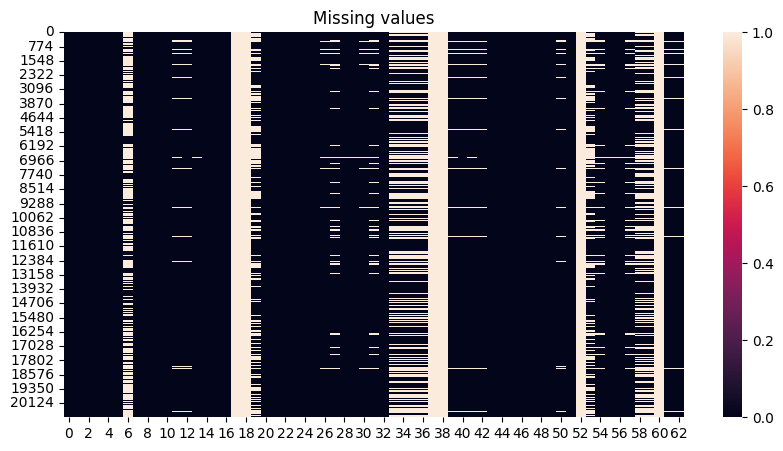

In [ ]:
#createing a missing values matrix

missing_mat = np.array(df_copy.isnull()).astype(int)

plt.figure(figsize=(10,5))
sns.heatmap(missing_mat).set_title('Missing values')
plt.show()

In [ ]:
df_copy.shape

(20884, 63)

In [ ]:
#for deleting cols that have more than 70% missing values, we check first the percentage of missing values

missing_prop_by_col = df_copy.isnull().sum(axis = 0).sort_values(ascending=False)/df.shape[0]

print(missing_prop_by_col)

Pre-Surgery Hospitalization Admission Time            1.0
Pre-Surgery Hospitalization Admission Date            1.0
Post-Surgery Discharge Date                           1.0
Pre-Surgery Hospitalization Admission Time_Minutes    1.0
Post-Surgery Discharge Time_Minutes                   1.0
                                                     ... 
Readmission                                           0.0
Planned Surgery Duration                              0.0
Closure DateTime                                      0.0
Exit DateTime                                         0.0
Incision DateTime                                     0.0
Length: 63, dtype: float64


In [ ]:
# % missing values
missing_prop_by_col = df_copy.isnull().sum(axis=0).sort_values(ascending=False) / df_copy.shape[0]
print(missing_prop_by_col)

#deleting cols that have more than 70% missing values
cols_to_drop = missing_prop_by_col[missing_prop_by_col >= 0.7].index
df_copy.drop(cols_to_drop, axis=1, inplace=True)

for col in cols_to_drop:
    if col in num_vars:
        num_vars.remove(col)
    elif col in cat_vars:
        cat_vars.remove(col)
    elif col in time_vars:
        time_vars.remove(col)

Pre-Surgery Hospitalization Admission Time            1.0
Pre-Surgery Hospitalization Admission Date            1.0
Post-Surgery Discharge Date                           1.0
Pre-Surgery Hospitalization Admission Time_Minutes    1.0
Post-Surgery Discharge Time_Minutes                   1.0
                                                     ... 
Readmission                                           0.0
Planned Surgery Duration                              0.0
Closure DateTime                                      0.0
Exit DateTime                                         0.0
Incision DateTime                                     0.0
Length: 63, dtype: float64


In [ ]:
df_copy.info() #Cancellation Reason on Surgery Day was deleted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20884 entries, 0 to 20883
Data columns (total 57 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   patient_id                                          20884 non-null  int64         
 1   Site Code                                           20884 non-null  object        
 2   Main Surgeon Code                                   20884 non-null  object        
 3   Activity Code                                       20884 non-null  object        
 4   Activity Type Code                                  20884 non-null  object        
 5   Planned SU Time (Large/Medium/Small)                20884 non-null  object        
 6   Pre-Surgery Admission Date                          7002 non-null   datetime64[ns]
 7   Height                                              20884 non-null  object        
 8   Weight

In case the percentage of missing is between 40-69%, the subsection should be made categorical.

In [ ]:
# Function that converts a time to a part of the day
def time_of_day(hour):
    if pd.isna(hour):
        return 0
    elif 5 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 17:
        return 2  # Noon
    elif 17 <= hour < 21:
        return 3  # Evening
    else:
        return 4  # Night

# Calculation of percentage deficiencies
missing_prop_by_col = df_copy.isnull().sum(axis=0).sort_values(ascending=False) / df_copy.shape[0]
print(missing_prop_by_col)

# Variables with medium missingness (for conversion to categories)
cols_to_categorize = missing_prop_by_col[(missing_prop_by_col >= 0.4) & (missing_prop_by_col < 0.7)].index

for col in cols_to_categorize:
    if col in num_vars:
        try:
            df_copy[col] = pd.qcut(df_copy[col], 4, labels=[1, 2, 3, 4], duplicates='drop')
            df_copy[col] = df_copy[col].cat.set_categories([0, 1, 2, 3, 4])
            df_copy[col] = df_copy[col].fillna(0)
            num_vars.remove(col)
            cat_vars.append(col)
        except Exception as e:
            print(f"Conversion error {col} to categories: {e}")

    elif col in time_vars:  # Time columns – already converted to *_Minutes
        try:
            hour_col = col.replace('_Minutes', '_hour')
            time_cat_col = col.replace('_Minutes', '_time_cat')

            df_copy[hour_col] = df_copy[col] // 60
            df_copy[time_cat_col] = df_copy[hour_col].apply(time_of_day)

            df_copy[time_cat_col] = pd.Categorical(
                df_copy[time_cat_col],
                categories=[0, 1, 2, 3, 4],
                ordered=True
            )

            cat_vars.append(time_cat_col)
            time_vars.remove(col)
        except Exception as e:
            print(f"Error converting {col} to time category: {e}")

    elif col in cat_vars:
        if df_copy[col].dtype.name != 'category':
            df_copy[col] = df_copy[col].astype('category')

        if 0 not in df_copy[col].cat.categories:
            df_copy[col] = df_copy[col].cat.add_categories([0])

        df_copy[col] = df_copy[col].fillna(0)

Pre-Surgery Admission Date                            0.664719
Recovery Room Exit Date                               0.393411
Recovery Room Exit Time                               0.393411
Recovery Room Entry Time_Minutes                      0.393411
Recovery Room Exit Time_Minutes                       0.393411
Recovery Room Entry Time                              0.393411
Recovery Room Entry Date                              0.393411
Pre-Surgical Admission Time Before Surgery            0.357594
Pre-Surgical Admission Time Before Surgery_Minutes    0.357594
Actual Surgery Room Entry Time                        0.094139
End of Surgery Time (Exit from OR)_Minutes            0.094139
End of Surgery Time (Exit from OR)                    0.094139
Actual Surgery Room Entry Time_Minutes                0.094139
Planned Surgery Date                                  0.037732
Planned Surgery Time_Minutes                          0.037636
Planned Surgery Time                                  0

Numerical → kstest

Categorical → chi-square

Time → depends on how you encode it:

As numbers → treat as numerical

As day parts → treat as categorical

Is there a relationship between the location of the missing values and other variables? :

In [ ]:
from scipy import stats

# Calculate proportion of missing values per column
missing_prop_by_col = df_copy.isnull().sum(axis=0).sort_values(ascending=False) / df_copy.shape[0]

# Select columns with missing values under 40%
cols_to_check_mechanism = missing_prop_by_col[(missing_prop_by_col > 0) & (missing_prop_by_col < 0.4)].index

# Dictionary to store p-values
p_values = {}

for col_missing in cols_to_check_mechanism:
    p_values[col_missing] = {}

    for col in df_copy.columns:
        if col_missing == col:
            continue  # Skip comparison with itself

        try:
            if col in num_vars:
                # Numerical variable → use Kolmogorov–Smirnov test
                s1 = df_copy[col].dropna()
                s2 = df_copy.loc[df_copy[col_missing].notnull(), col].dropna()
                _, p = stats.ks_2samp(s1, s2)

            elif col in time_vars:
                # Time variable → extract hour and treat as numerical
                temp_hour = df_copy[col].dt.hour
                s1 = temp_hour.dropna()
                s2 = temp_hour[df_copy[col_missing].notnull()].dropna()
                _, p = stats.ks_2samp(s1, s2)

            elif col in time_vars:
                s1 = df_copy[col].dropna()
                s2 = df_copy.loc[df_copy[col_missing].notnull(), col].dropna()
                _, p = stats.ks_2samp(s1, s2)


            elif col in cat_vars or df_copy[col].dtype.name == 'category':
                # Categorical variable → Chi-Square test
                s1 = df_copy[col_missing].isnull().astype(int)
                s2 = df_copy[col]
                table = pd.crosstab(s1, s2)
                _, p, _, _ = stats.chi2_contingency(table)

            else:
                # Default: treat as categorical
                s1 = df_copy[col_missing].isnull().astype(int)
                s2 = df_copy[col]
                table = pd.crosstab(s1, s2)
                _, p, _, _ = stats.chi2_contingency(table)

            p_values[col_missing][col] = p

        except Exception as e:
            print(f"Skipping {col_missing} vs {col}: {e}")

Skipping Recovery Room Exit Date vs Planned Surgery Time: Can only use .dt accessor with datetimelike values
Skipping Recovery Room Exit Date vs Administrative Admission Time: Can only use .dt accessor with datetimelike values
Skipping Recovery Room Exit Date vs Pre-Surgical Admission Time Before Surgery: Can only use .dt accessor with datetimelike values
Skipping Recovery Room Exit Date vs Actual Surgery Room Entry Time: Can only use .dt accessor with datetimelike values
Skipping Recovery Room Exit Date vs Incision Time: Can only use .dt accessor with datetimelike values
Skipping Recovery Room Exit Date vs Closure Time: Can only use .dt accessor with datetimelike values
Skipping Recovery Room Exit Date vs End of Surgery Time (Exit from OR): Can only use .dt accessor with datetimelike values
Skipping Recovery Room Exit Date vs Recovery Room Entry Time: Can only use .dt accessor with datetimelike values
Skipping Recovery Room Exit Date vs Recovery Room Exit Time: Can only use .dt access

In [ ]:
p_values

{'Recovery Room Exit Date': {'patient_id': np.float64(0.49674659516648234),
  'Site Code': 1.0,
  'Main Surgeon Code': np.float64(0.0),
  'Activity Code': np.float64(0.0),
  'Activity Type Code': np.float64(0.0),
  'Planned SU Time (Large/Medium/Small)': np.float64(5.988349240301459e-71),
  'Pre-Surgery Admission Date': np.float64(1.0),
  'Height': np.float64(1.9889096526404084e-30),
  'Weight': np.float64(2.0252353787081084e-23),
  'Patient Age (on Surgery Day)': np.float64(1.4062464978137242e-97),
  'Background Diseases/Diagnoses': np.float64(5.1777738698875955e-54),
  'Planned Surgery Date': np.float64(1.0),
  'Surgery Admission Date': np.float64(1.0),
  'אתר מתוכנן': np.float64(4.356316509489891e-22),
  'Planned Operating Room Number': np.float64(0.0),
  'Surgical Team Codes': np.float64(2.4305768218315e-310),
  'Anesthesiologist Code': np.float64(0.0),
  'Anesthesia Code': np.float64(0.0),
  'Type of Anesthesia': np.float64(0.0),
  'Cancellation Reason on Surgery Day': 1.0,
  'Act

In [ ]:
p_values_df = pd.DataFrame(p_values).T
p_values_df <= 0.05 #in a comparison of all the variables with the variables with under 40% missing values
p_values_df

,patient_id,Site Code,Main Surgeon Code,Activity Code,Activity Type Code,Planned SU Time (Large/Medium/Small),Pre-Surgery Admission Date,Height,Weight,Patient Age (on Surgery Day),...,Pre-Surgical Admission Time Before Surgery_Minutes,Actual Surgery Room Entry Time_Minutes,Incision Time_Minutes,Closure Time_Minutes,End of Surgery Time (Exit from OR)_Minutes,Recovery Room Entry Time_Minutes,Recovery Room Exit Time_Minutes,Planned Start Time for Doctor Block_Minutes,Planned End Time for Doctor Block_Minutes,Recovery Room Exit Date
Recovery Room Exit Date,0.496747,1.0,0.000000e+00,0.000000e+00,0.000000e+00,5.988349e-71,1.0,1.988910e-30,2.025235e-23,1.406246e-97,...,0.86656,6.858050e-01,7.993550e-02,5.048030e-02,5.320977e-01,1.000000e+00,1.000000e+00,2.531647e-02,8.063611e-02,NaN
Recovery Room Exit Time,0.496747,1.0,0.000000e+00,0.000000e+00,0.000000e+00,5.988349e-71,1.0,1.988910e-30,2.025235e-23,1.406246e-97,...,0.86656,6.858050e-01,7.993550e-02,5.048030e-02,5.320977e-01,1.000000e+00,1.000000e+00,2.531647e-02,8.063611e-02,1.0
Recovery Room Entry Time_Minutes,0.496747,1.0,0.000000e+00,0.000000e+00,0.000000e+00,5.988349e-71,1.0,1.988910e-30,2.025235e-23,1.406246e-97,...,0.86656,6.858050e-01,7.993550e-02,5.048030e-02,5.320977e-01,NaN,1.000000e+00,2.531647e-02,8.063611e-02,1.0
Recovery Room Exit Time_Minutes,0.496747,1.0,0.000000e+00,0.000000e+00,0.000000e+00,5.988349e-71,1.0,1.988910e-30,2.025235e-23,1.406246e-97,...,0.86656,6.858050e-01,7.993550e-02,5.048030e-02,5.320977e-01,1.000000e+00,NaN,2.531647e-02,8.063611e-02,1.0
Recovery Room Entry Time,0.496747,1.0,0.000000e+00,0.000000e+00,0.000000e+00,5.988349e-71,1.0,1.988910e-30,2.025235e-23,1.406246e-97,...,0.86656,6.858050e-01,7.993550e-02,5.048030e-02,5.320977e-01,1.000000e+00,1.000000e+00,2.531647e-02,8.063611e-02,1.0
Recovery Room Entry Date,0.496747,1.0,0.000000e+00,0.000000e+00,0.000000e+00,5.988349e-71,1.0,1.988910e-30,2.025235e-23,1.406246e-97,...,0.86656,6.858050e-01,7.993550e-02,5.048030e-02,5.320977e-01,1.000000e+00,1.000000e+00,2.531647e-02,8.063611e-02,1.0
Pre-Surgical Admission Time Before Surgery,0.496747,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.081735e-93,1.120166e-52,5.558719e-18,...,1.00000,1.720937e-26,9.007155e-28,6.545574e-37,3.726316e-38,1.461475e-26,6.978788e-22,1.388254e-28,1.415072e-29,1.0
Pre-Surgical Admission Time Before Surgery_Minutes,0.496747,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.081735e-93,1.120166e-52,5.558719e-18,...,NaN,1.720937e-26,9.007155e-28,6.545574e-37,3.726316e-38,1.461475e-26,6.978788e-22,1.388254e-28,1.415072e-29,1.0
Actual Surgery Room Entry Time,0.496747,1.0,0.000000e+00,0.000000e+00,0.000000e+00,3.624428e-195,1.0,9.525717e-04,2.183061e-02,3.427556e-08,...,1.00000,1.000000e+00,4.767948e-01,3.794950e-01,1.000000e+00,1.000000e+00,9.999995e-01,2.846784e-04,1.801068e-05,1.0
End of Surgery Time (Exit from OR)_Minutes,0.496747,1.0,0.000000e+00,0.000000e+00,0.000000e+00,3.624428e-195,1.0,9.525717e-04,2.183061e-02,3.427556e-08,...,1.00000,1.000000e+00,4.767948e-01,3.794950e-01,NaN,1.000000e+00,9.999995e-01,2.846784e-04,1.801068e-05,1.0


In [ ]:
p_values_df = pd.DataFrame(p_values).T
p_values_df = p_values_df <= 0.05 #in a comparison of all the variables with the variables with under 40% missing values
p_values_df

,patient_id,Site Code,Main Surgeon Code,Activity Code,Activity Type Code,Planned SU Time (Large/Medium/Small),Pre-Surgery Admission Date,Height,Weight,Patient Age (on Surgery Day),...,Pre-Surgical Admission Time Before Surgery_Minutes,Actual Surgery Room Entry Time_Minutes,Incision Time_Minutes,Closure Time_Minutes,End of Surgery Time (Exit from OR)_Minutes,Recovery Room Entry Time_Minutes,Recovery Room Exit Time_Minutes,Planned Start Time for Doctor Block_Minutes,Planned End Time for Doctor Block_Minutes,Recovery Room Exit Date
Recovery Room Exit Date,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,True,False,False
Recovery Room Exit Time,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,True,False,False
Recovery Room Entry Time_Minutes,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,True,False,False
Recovery Room Exit Time_Minutes,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,True,False,False
Recovery Room Entry Time,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,True,False,False
Recovery Room Entry Date,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,True,False,False
Pre-Surgical Admission Time Before Surgery,False,False,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,False
Pre-Surgical Admission Time Before Surgery_Minutes,False,False,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,False
Actual Surgery Room Entry Time,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,True,True,False
End of Surgery Time (Exit from OR)_Minutes,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,False,False,True,True,False


In [ ]:
p_values_df['num_of_affecting_columns'] = (p_values_df).sum(axis=1)
p_values_df['MCAR'] = p_values_df['num_of_affecting_columns'] == 0
p_values_df

,patient_id,Site Code,Main Surgeon Code,Activity Code,Activity Type Code,Planned SU Time (Large/Medium/Small),Pre-Surgery Admission Date,Height,Weight,Patient Age (on Surgery Day),...,Incision Time_Minutes,Closure Time_Minutes,End of Surgery Time (Exit from OR)_Minutes,Recovery Room Entry Time_Minutes,Recovery Room Exit Time_Minutes,Planned Start Time for Doctor Block_Minutes,Planned End Time for Doctor Block_Minutes,Recovery Room Exit Date,num_of_affecting_columns,MCAR
Recovery Room Exit Date,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,True,False,False,22,False
Recovery Room Exit Time,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,True,False,False,22,False
Recovery Room Entry Time_Minutes,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,True,False,False,22,False
Recovery Room Exit Time_Minutes,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,True,False,False,22,False
Recovery Room Entry Time,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,True,False,False,22,False
Recovery Room Entry Date,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,True,False,False,22,False
Pre-Surgical Admission Time Before Surgery,False,False,True,True,True,True,False,True,True,True,...,True,True,True,True,True,True,True,False,30,False
Pre-Surgical Admission Time Before Surgery_Minutes,False,False,True,True,True,True,False,True,True,True,...,True,True,True,True,True,True,True,False,30,False
Actual Surgery Room Entry Time,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,True,True,False,22,False
End of Surgery Time (Exit from OR)_Minutes,False,False,True,True,True,True,False,True,True,True,...,False,False,False,False,False,True,True,False,22,False


If MCAR = False: we categorize

if MCAR = True: we impute.

In [ ]:
cols_to_impute = list(p_values_df.query('MCAR == True').index)
cols_to_categorize = list(p_values_df.query('MCAR == False').index)

We use 2 patterns of missing data in the df. MCAR (Missing Completely at Random): the probability of a data point being missing is unrelate to both observed and unobserved data.

MAR (Missing at Random): the probability of a data point being missing can be related to the observed values, but not to the values that are missing.

In [ ]:
cols_to_impute

[]

In [ ]:
cols_to_categorize

['Recovery Room Exit Date',
 'Recovery Room Exit Time',
 'Recovery Room Entry Time_Minutes',
 'Recovery Room Exit Time_Minutes',
 'Recovery Room Entry Time',
 'Recovery Room Entry Date',
 'Pre-Surgical Admission Time Before Surgery',
 'Pre-Surgical Admission Time Before Surgery_Minutes',
 'Actual Surgery Room Entry Time',
 'End of Surgery Time (Exit from OR)_Minutes',
 'End of Surgery Time (Exit from OR)',
 'Actual Surgery Room Entry Time_Minutes',
 'Planned Surgery Date',
 'Planned Surgery Time_Minutes',
 'Planned Surgery Time',
 'Planned End Date for Doctor Block',
 'Planned Start Date for Doctor Block',
 'Planned Start Time for Doctor Block',
 'Planned End Time for Doctor Block',
 'Planned End Time for Doctor Block_Minutes',
 'Planned Start Time for Doctor Block_Minutes',
 'End of Surgery Date (Exit from OR)',
 'Actual Surgery Room Entry Date',
 'Closure Time_Minutes',
 'Incision Time',
 'Incision Time_Minutes',
 'Closure Time',
 'Surgery Admission Date',
 'Administrative Admission 

Imputation: We will replace the missing values with neighboring values according to the nearest neighbors method (KNN).

In [ ]:
from sklearn.impute import KNNImputer

# Check if there are missing values in the specified columns
if df_copy[cols_to_impute].isnull().any().any():
    # If there are missing values, impute them using KNNImputer
    imputer = KNNImputer(n_neighbors=3)
    df_copy[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])
else:
    print("No missing values found in the specified columns.")

No missing values found in the specified columns.


<Axes: >

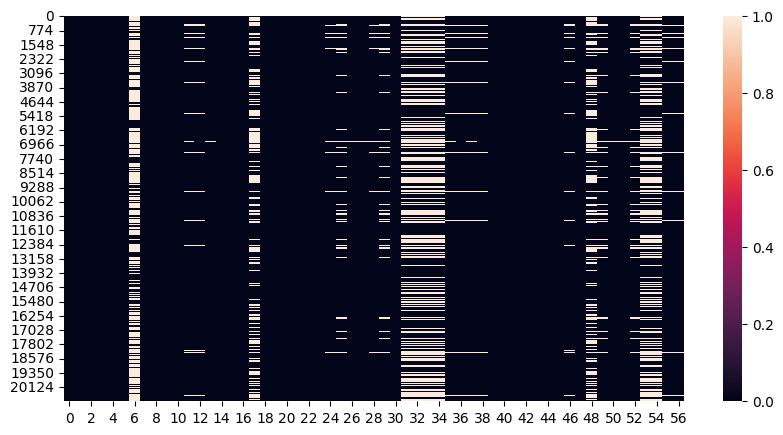

In [ ]:
missing_mat = np.array(df_copy.isnull()).astype(int)

plt.figure(figsize=(10,5))
sns.heatmap(missing_mat)

Categorization:

In [ ]:
len(cols_to_categorize)

30

In [ ]:
# Convert original time columns to minutes since midnight (if not done yet)
def time_to_minutes(t):
    if pd.isnull(t):
        return None
    try:
        return t.hour * 60 + t.minute + t.second / 60
    except:
        return None

original_time_cols = [
    'Planned Surgery Time',
    'Administrative Admission Time',
    'Pre-Surgery Hospitalization Admission Time',
    'Pre-Surgical Admission Time Before Surgery',
    'Actual Surgery Room Entry Time',
    'Incision Time',
    'Closure Time',
    'End of Surgery Time (Exit from OR)',
    'Recovery Room Entry Time',
    'Recovery Room Exit Time',
    'Post-Surgery Discharge Time',
    'Planned Start Time for Doctor Block',
    'Planned End Time for Doctor Block'
]

# Create _Minutes columns if missing
for col in original_time_cols:
    col_minutes = col + "_Minutes"
    if col in df_copy.columns and col_minutes not in df_copy.columns:
        df_copy[col_minutes] = pd.to_datetime(df_copy[col], errors='coerce').apply(time_to_minutes)

# Add _Minutes time columns to num_vars
time_minute_vars = [col + "_Minutes" for col in original_time_cols if col + "_Minutes" in df_copy.columns]
num_vars += time_minute_vars

# Define categorization function
def categorize_columns(cols_to_categorize, num_vars=[], cat_vars=[], time_vars=[]):
    def time_of_day(hour):
        if pd.isna(hour):
            return 0
        elif 5 <= hour < 12:
            return 1  # Morning
        elif 12 <= hour < 17:
            return 2  # Afternoon
        elif 17 <= hour < 21:
            return 3  # Evening
        else:
            return 4  # Night

    global df_copy

    for col in cols_to_categorize:
        if col in num_vars:
            try:
                df_copy[col] = pd.qcut(df_copy[col], 4, labels=[1, 2, 3, 4], duplicates='drop')
                df_copy[col] = df_copy[col].cat.set_categories([0, 1, 2, 3, 4])
                df_copy[col] = df_copy[col].fillna(0)
                num_vars.remove(col)
                cat_vars.append(col)
            except Exception as e:
                print(f"Skipping numerical column {col} due to error: {e}")

        elif col in time_vars:
            try:
                hour_col = col.replace('_Minutes', '_hour')
                time_cat_col = col.replace('_Minutes', '_time_cat')
                df_copy[hour_col] = df_copy[col] // 60
                df_copy[time_cat_col] = df_copy[hour_col].apply(time_of_day)
                df_copy[time_cat_col] = pd.Categorical(df_copy[time_cat_col], categories=[0, 1, 2, 3, 4], ordered=True)
                cat_vars.append(time_cat_col)
                time_vars.remove(col)
            except Exception as e:
                print(f"Error converting {col} to time category: {e}")

        else:
            if pd.api.types.is_categorical_dtype(df_copy[col]):
                if 0 not in df_copy[col].cat.categories:
                    df_copy[col] = df_copy[col].cat.add_categories([0])
                df_copy[col] = df_copy[col].fillna(0)
            else:
                unique_categories = df_copy[col].dropna().unique()
                df_copy[col] = pd.Categorical(df_copy[col], categories=[0] + list(unique_categories))
                df_copy[col] = df_copy[col].fillna(0)
            if col not in cat_vars:
                cat_vars.append(col)

    return num_vars, cat_vars, time_vars

# Final call to categorize
num_vars, cat_vars, time_vars = categorize_columns(cols_to_categorize, num_vars, cat_vars, time_vars)

Error converting Recovery Room Exit Date to time category: cannot perform __floordiv__ with this index type: DatetimeArray
Error converting Recovery Room Exit Time to time category: unsupported operand type(s) for //: 'datetime.time' and 'int'
Error converting Recovery Room Entry Time to time category: unsupported operand type(s) for //: 'datetime.time' and 'int'
Error converting Recovery Room Entry Date to time category: cannot perform __floordiv__ with this index type: DatetimeArray
Error converting Pre-Surgical Admission Time Before Surgery to time category: unsupported operand type(s) for //: 'datetime.time' and 'int'
Error converting Actual Surgery Room Entry Time to time category: unsupported operand type(s) for //: 'datetime.time' and 'int'
Error converting End of Surgery Time (Exit from OR) to time category: unsupported operand type(s) for //: 'datetime.time' and 'int'
Error converting Planned Surgery Date to time category: cannot perform __floordiv__ with this index type: Date

Because we cleared the original data, there would be no longer missing values, thus I update the df to be without the missing values- there were no longer missing values at our original data- so there would no longer be missing values at out engineered data.

In [ ]:
df_no_missing = df_copy.dropna()
df_copy = df_no_missing

In [ ]:
df_no_missing.isnull().sum()

,0
patient_id,0
Site Code,0
Main Surgeon Code,0
Activity Code,0
Activity Type Code,0
Planned SU Time (Large/Medium/Small),0
Pre-Surgery Admission Date,0
Height,0
Weight,0
Patient Age (on Surgery Day),0


In [ ]:
!pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=141b9c2b73e4a061f10920b7a148deae6848aa56b01f61aa6cdd9c74b84495d2
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df_copy, title="Pandas Profiling Report", explorative=True)
profile.to_file("profile_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 57/57 [00:04<00:00, 11.71it/s]
/usr/local/lib/python3.11/dist-packages/ydata_profiling/model/missing.py:132: UserWarning: There was an attempt to generate the Heatmap missing values diagrams, but this failed.
        To hide this warning, disable the calculation
        (using `df.profile_report(missing_diagrams={"Heatmap": False}`)
        If this is problematic for your use case, please report this as an issue:
        https://github.com/ydataai/ydata-profiling/issues
        (include the error message: 'max() arg is an empty sequence')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/ydata_profiling/visualisation/plot.py:429: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_copy.to_excel("2024_data_Assuta_nomissings_for_stat_final_2705.xlsx", index=False)

###Note: Because all the information was provided with the year 2023, but the hospital manager said that the information is for 2024, please see another file where all the years are transferred to 2024.